In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
DATA_DIR = Path("/Users/sean/code/study-hard/power-systems-ops/data/" )
STUDY_DIR = DATA_DIR / "Multi-Stage_Aging_Study"

In [4]:
from power_systems_ops.battery.calendar_aging import extract_results

In [5]:
results = extract_results(STUDY_DIR)

experiment 0
Matching files: 13
/Users/sean/code/study-hard/power-systems-ops/data/Multi-Stage_Aging_Study/Stage_1/47627050_TP_k01_01/TP_k01_01/TP_k01_01_01_ET_T45.csv
Initial runtimes:  [np.float64(48607.304), np.float64(738360.397), np.float64(315208.113), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(13435.603), np.float64(0.001), np.float64(255530.15)]
Found 9 at same temp
Time:  [0.0, 6.857142857142857, 11.857142857142858, 18.857142857142858, 26.857142857142858, 34.857142857142854, 38.57142857142857, 50.857142857142854, 52.714285714285715]
Found (c0, beta, error): (4.903446300769325, -0.00043959819990871895, [0.01607585])
experiment 1
Matching files: 13
/Users/sean/code/study-hard/power-systems-ops/data/Multi-Stage_Aging_Study/Stage_1/47627056_TP_k01_02/TP_k01_02/TP_k01_02_03_exCU.csv
Initial runtimes:  [np.float64(48149.28), np.float64(735362.737), np.float64(312180.516), np.float64(0.0), np.float

In [88]:
from power_systems_ops.battery.calendar_aging import capacity_vs_time, extract_calendar

In [89]:
from power_systems_ops.battery.data_import import import_datafile

# Calendar Aging

In [90]:
# Select the dataset to be imported
stage = 1   # Doesn't matter to me
aging_type = 'k'  # Calendar (k) and Cycling (z)

tp = 1  # Experiment Number
cell = 4  # Cell Number
T_amb = 10

files = find_files(stage, aging_type, tp, cell)
t, cap, _ = capacity_vs_time(files, T_amb)

Matching files: 6
/Users/sean/code/study-hard/power-systems-ops/data/Multi-Stage_Aging_Study/Stage_1/47639005_TP_k01_04/TP_k01_04/TP_k01_04_01_ET_T10.csv
Found 2 at same temp


[0, 63, 14, 2562, 2562, 2562]

In [67]:
from datetime import datetime

In [69]:
datetime(year=2020, month=12, day=30)

datetime.datetime(2020, 12, 30, 0, 0)

In [77]:
def meta(file):
    m = file.parent / (file.stem + "_meta.txt")
    if not m.exists():
        raise FileNotFoundError("Couldn't find: {m}")
    return m
    

def measurement_date(meta_path):
    with open(meta_path, 'r') as file:
        for line in file:
            words = line.split("Measurement start date: ")
            if len(words) == 2:
                day, month, year = [int(s) for s in words[1].split(".")]
                return datetime(year=year, month=month, day=day)
    raise ValueError(f"Failed to find measurement date for file: {meta_path.name}")

In [83]:
(datetime(2020, 5, 20) - datetime(2020, 5, 5)).days

15

In [76]:
measurement_date(f)

datetime.datetime(2021, 9, 21, 0, 0)

In [35]:
cap = np.array([extract_calendar(import_datafile(f)) for f in files])

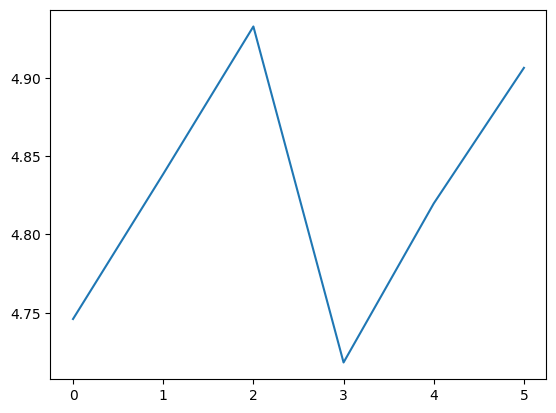

In [36]:
plt.plot(cap[:, 0])

In [39]:
import_datafile(files[0])

,run_time,c_vol,c_cur,c_surf_temp,amb_temp,step_type
0,0.000,2.638390,0.0,33.51043,NaN,0
1,10.116,2.783600,0.0,33.55171,NaN,0
2,20.111,2.821765,0.0,33.47334,NaN,0
3,30.111,2.844574,0.0,33.37616,NaN,0
4,40.111,2.860382,0.0,33.25390,NaN,0
...,...,...,...,...,...,...
310769,258538.747,4.087777,0.0,10.93668,NaN,0
310770,258548.747,4.087777,0.0,10.93668,NaN,0
310771,258558.747,4.087551,0.0,10.93668,NaN,0
310772,258568.747,4.087551,0.0,10.93668,NaN,0


In [38]:
cap[:, 1]

array([nan, nan, nan, nan, nan, nan])

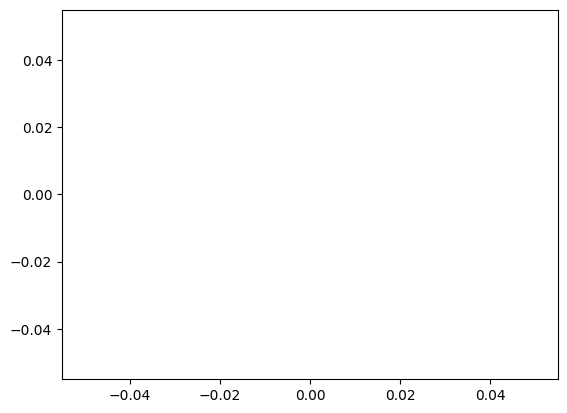

In [37]:
plt.plot(cap[:, 1])

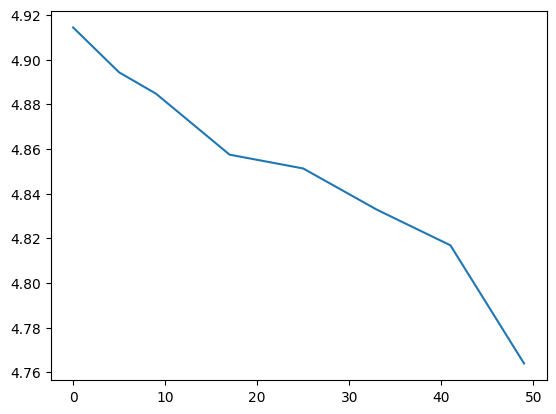

In [26]:
plt.plot(t, cap)

In [107]:
beta = np.asarray([beta for _, beta in results])
T_amb = np.asarray([row.amb_temp_tp for row, _ in results])
SoC = np.asarray([row.soc_max_tp for row, _ in results])


In [108]:
def fit_each_temp(SoC, beta, T_amb):
    SoC_range = np.array([min(SoC), max(SoC)])
    beta_fit = {}
    
    np.unique(T_amb)
    for T in np.unique(T_amb):
        n_match = np.sum(T_amb == T)
        A = np.c_[
            np.ones(n_match), SoC[T_amb == T]
        ]
        b = beta[T_amb == T]
        # beta_q = x[0] + x[1] * q
        x = np.linalg.lstsq(A, b)[0]
        beta_fit[T] = x[0] + x[1] * SoC_range

    return SoC_range, beta_fit

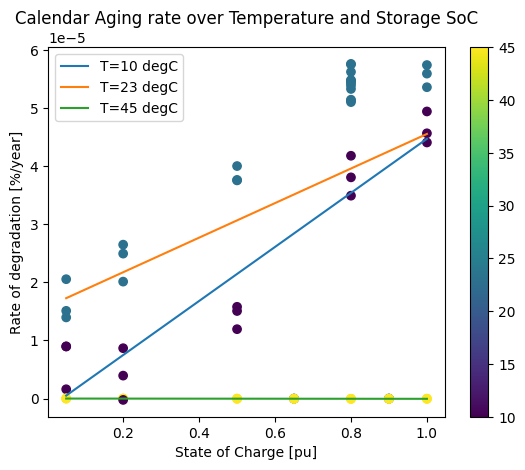

In [111]:
def plot_soc_dependence(SoC, beta, T_amb, fit_result):
    SoC_range, beta_fit = fit_result

    fig = plt.figure()
    plt.scatter(x=SoC, y=beta, c=T_amb, marker="o")
    for T, beta_f in beta_fit.items():
        plt.plot(SoC_range, beta_f, label=f"T={T} degC")
    plt.colorbar()
    plt.title("Calendar Aging rate over Temperature and Storage SoC")
    plt.legend()
    plt.xlabel("State of Charge [pu]")
    plt.ylabel("Rate of degradation [%/year]")
    return fig

beta_fit = fit_each_temp(SoC, beta, T_amb)
plot_soc_dependence(SoC, beta, T_amb, beta_fit)
None
                 

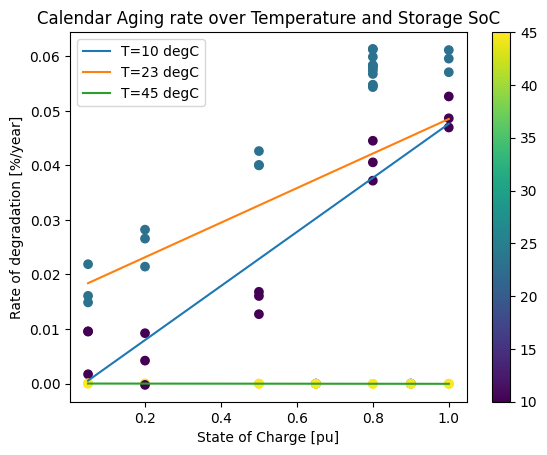

In [112]:
# (Ah) / Ah_total * 100 / week => percentage / week * 365 days/year * 1day/7weeks
Ah_total = 4.9
beta_pu = beta / Ah_total * 100 * 365 / 7
beta_pu_fit = fit_each_temp(SoC, beta_pu, T_amb)
fig = plot_soc_dependence(SoC, beta_pu, T_amb, beta_pu_fit)

In [21]:
fig.savefig(DATA_DIR / "battery_deg" / "deg_vs_soc.png")

(array([ 7.,  9.,  8., 12., 15.,  3.,  2.,  4.,  1.,  5.]),
 array([8.21650231e-05, 7.78965335e-04, 1.47576565e-03, 2.17256596e-03,
        2.86936627e-03, 3.56616658e-03, 4.26296689e-03, 4.95976720e-03,
        5.65656752e-03, 6.35336783e-03, 7.05016814e-03]),
 <BarContainer object of 10 artists>)

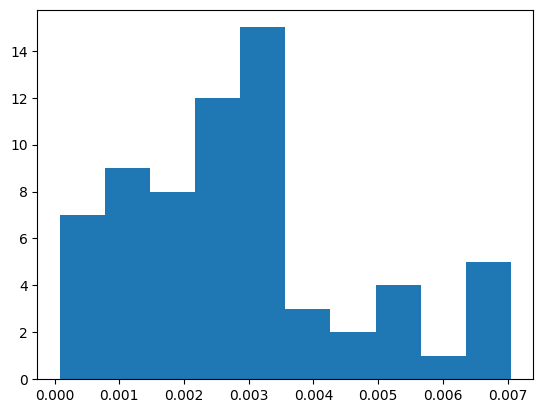

In [22]:
plt.hist(beta)

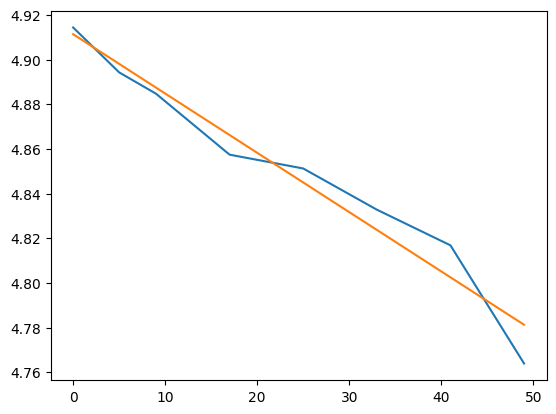

In [113]:
# Linear estimate
t_hat = np.linspace(min(t), max(t))
c_hat = c0 + t_hat * beta
plt.plot(calendar_cap[:, 2], calendar_cap[:, 0])
plt.plot(t_hat, c_hat)

In [85]:
t

array([0, 5, 4, 8, 8, 8, 8, 8, 8, 8, 8])

In [86]:
len(f_cap)

8

In [71]:
len(t)

3

In [46]:
np.mean(cap[:, 1])

np.float64(26.53690039948746)

In [44]:
print(cap[:, 1])

[ 9.99268283 22.99405867 45.03137021 22.98548617 22.99717379 23.00592945
 22.99203482 23.00379667 22.99595199  9.99119203 25.48132213 66.97180603]


In [43]:
print(cap.shape)

(12, 2)


In [35]:
df = import_datafile(file[0])
df.head()

,run_time,c_vol,c_cur,c_surf_temp,amb_temp,step_type
0,0.0000,3.515543,0.0,35.57893,0.000000,0
1,0.0021,3.515543,0.0,35.57893,0.000000,0
2,10.0000,3.516306,0.0,35.57565,35.004673,0
3,20.0000,3.516497,0.0,35.57565,34.983028,0
4,30.0000,3.515543,0.0,35.57565,35.004917,0


In [46]:
np.nanmean([np.nan, np.nan])

/var/folders/t2/6c2q8fsd3dq21_7dzq7c6n6w0000gn/T/ipykernel_34381/2006840581.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean([np.nan, np.nan])


np.float64(nan)

In [21]:
T

np.float64(23.015748436976764)

In [18]:
file[0].name

'TP_z08_01_11_CU.csv'

In [17]:
c

np.float64(4.780677173083463)

In [15]:
c

{'Q_mean': np.float64(4.780677173083463),
 'Q_ch': np.float64(4.774801425046293),
 'Q_dch': np.float64(4.7865529211206335),
 'q_ch': array([    0.        ,    24.49545658,    48.99492707,    73.49507939,
           97.99596672,   122.49595957,   146.99521742,   171.4948917 ,
          195.99567271,   220.49571872,   244.99571157,   269.49491665,
          293.99469726,   318.49479642,   342.99515293,   367.49514578,
          391.99435086,   416.49445003,   440.99439012,   465.49476704,
          489.99516437,   514.49485945,   538.99448097,   563.49420841,
          587.99446706,   612.49461939,   636.99482488,   661.49529577,
          685.99569309,   710.49538818,   734.99516878,   759.49500255,
          783.99526119,   808.4953072 ,   832.99570453,   857.49539961,
          881.99539286,   906.49549202,   930.9958566 ,   955.49595576,
          979.99605493,  1004.49645226,  1028.99598786,  1053.49643835,
         1077.99639884,  1102.4962326 ,  1126.99622545,  1151.49611237,
    